In [1]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pickle 
import os
import sys

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from hyperopt import hp, tpe, fmin, Trials, rand
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

from preprocessing.utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

In [5]:
REPO_ID = "inria-soda/tabular-benchmark"
clf_cat = [
    # 'albert.csv', 
   # 'compas-two-years.csv', 
   # 'covertype.csv', 
   # 'default-of-credit-card-clients.csv',
   'electricity.csv',
   # 'eye_movements.csv',
   # 'road-safety.csv'
]

clf_num = [
    'Bioresponse.csv',
    # 'Diabetes130US.csv',
    # 'Higgs.csv',
    # 'MagicTelescope.csv',
    # 'MiniBooNE.csv',
    # 'bank-marketing.csv',
    # 'california.csv',
    # 'covertype.csv',
    # 'credit.csv',
    # 'default-of-credit-card-clients.csv',
    # 'electricity.csv',
    # 'eye_movements.csv',
    # 'heloc.csv',
    # 'house_16H.csv',
    # 'jannis.csv',
    # 'pol.csv'
]

reg_cat = [
    # 'Airlines_DepDelay_1M.csv',
    # 'Allstate_Claims_Severity.csv',
    # 'Bike_Sharing_Demand.csv',
    # 'Brazilian houses.csv',
    # 'Mercedes_Benz_Greener_Manufacturing.csv',
    # 'SGEMM_GPU_kernel_performance.csv',
    # 'abalone.csv',
    # 'analcatdata_supreme.csv',
    # 'delays_zurich_transport.csv',
    # 'diamonds.csv',
    'house_sales.csv',
    # 'medical_charges.csv',
    # 'nyc-taxi-green-dec-2016.csv',
    # 'particulate-matter-ukair-2017.csv',
    # 'seattlecrime6.csv',
    # 'topo_2_1.csv',
    # 'visualizing_soil.csv'
]

reg_num = [
    'Ailerons.csv',
    'Bike_Sharing_Demand.csv',
    'Brazilian houses.csv',
    'MiamiHousing2016.csv',
    'abalone.csv',
    'cpu_act.csv',
    'delays_zurich_transport.csv',
    'diamonds.csv',
    'elevators.csv',
    'house_16H.csv',
    'house_sales.csv',
    'houses.csv',
    'medical_charges.csv',
    'nyc-taxi-green-dec-2016.csv',
    'pol.csv',
    'sulfur.csv',
    'superconduct.csv',
    'wine_quality.csv',
    'yprop_4_1.csv'
]

In [6]:
def sample_hpt_from_space(space, n_samples = 100) :
    return [sample(space) for _ in range(n_samples)]

In [7]:
def print_info(iter_number, total_iterations, dct=None):
    arrow_length = 30
    progress = int((iter_number / total_iterations) * arrow_length)
    progress_bar = "=" * progress + ">"
    info_string = "\rIteration: [{:<30}] {}/{}".format(progress_bar, iter_number, total_iterations)
    if dct is not None:
        info_string += ", {}".format(dct)
    sys.stdout.write(info_string.ljust(100))  # Adjust the total length as needed
    sys.stdout.flush()
    
def evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val) :
    model.fit(X_train, y_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)
    train_predict = model.predict(X_train)
    val_score = accuracy_score(y_val, val_predict)
    test_score = accuracy_score(y_test, test_predict)
    train_score = accuracy_score(y_train, train_predict)
    return {'val_accuracy' : val_score, 
            'test_accuracy' : test_score, 
           'train_accuracy' : train_score, 
           'hyperparameters' : hyperparameters}

In [14]:
if not os.path.exists('gradient-boosting-results') :
    os.makedirs('gradient-boosting-results')

if not os.path.exists('random-forest-results') :
    os.makedirs('random-forest-results')
    
if not os.path.exists('xgboost-results') :
    os.makedirs('xgboost-results')

np.random.seed(42)
n_iterations = 20
n_shuffles = 5
random_shuffle_indices = np.array([np.random.permutation(n_iterations) for _ in range(n_shuffles)])

clf_cat_random_forest_scores = np.zeros((n_shuffles, n_iterations))
clf_cat_gradient_boosting_scores = np.zeros((n_shuffles, n_iterations))
clf_cat_xgboost_scores = np.zeros((n_shuffles, n_iterations))

random_forest_hyperparameter_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(9.5), np.log(3000.5))),
    'max_depth': hp.pchoice('max_depth', [
        (0.7, None),
        (0.1, 2),
        (0.1, 3),
        (0.1, 4)
    ]),
    'min_samples_split': hp.pchoice('min_samples_split', [(0.95, 2), (0.05, 3)]),
    'min_samples_leaf': scope.int(hp.loguniform('min_samples_leaf', np.log(1.5), np.log(50.5))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['sqrt', 'sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'min_impurity_decrease': hp.pchoice('min_impurity_decrease', [
        (0.85, 0.0), 
        (0.05, 0.01), 
        (0.05, 0.02), 
        (0.05, 0.05)
    ])
}
random_forest_hpt_samples = sample_hpt_from_space(random_forest_hyperparameter_space, n_samples=n_iterations)

gradient_boosting_hyperparameter_space = {
    'loss': hp.choice('loss', ['exponential', 'log_loss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'n_estimators': scope.int(hp.qloguniform('n_estimators', np.log(10.5), np.log(1000.5), 1)),
    'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'max_depth': hp.pchoice('max_depth', [(0.1, None), (0.1, 2), (0.1, 3), (0.6, 4), (0.1, 5)]),
    'min_samples_split': hp.pchoice('min_samples_split', [(0.95, 2), (0.05, 3)]),
    'min_samples_leaf': scope.int(hp.qloguniform('min_samples_leaf', np.log(1.5), np.log(50.5), 1)),
    'min_impurity_decrease': hp.pchoice('min_impurity_decrease', [(0.85, 0.0), (0.05, 0.01), (0.05, 0.02), (0.05, 0.05)]),
    'max_leaf_nodes': hp.pchoice('max_leaf_nodes', [(0.85, None), (0.05, 5), (0.05, 10), (0.05, 15)])
}
gradient_boosting_hpt_samples = sample_hpt_from_space(gradient_boosting_hyperparameter_space, n_samples=n_iterations)

xgboost_hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}
xgboost_hpt_samples = sample_hpt_from_space(xgboost_hyperparameter_space, n_samples=n_iterations)


for dataset_idx, dataset in enumerate(clf_num) :
    print(f'Evaluating {dataset}...')

    df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=f'clf_num/{dataset}', repo_type="dataset")
    )
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = preprocess_data(X, y, isCategorical=True)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)
    print(f'Training data : {len(X_train)}\nValidation data : {len(X_val)}\nTesting data : {len(X_test)}')
    
    for random_shuffle_idx in range(n_shuffles) :

        #Random Forest
        print('\nRunning Random Forest...')
        
        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]) :
            print_info(hpt_idx+1, n_iterations)
            hyperparameters = random_forest_hpt_samples[i]
            print('000000000=============-------------')
            print(hyperparameters)
            if hpt_idx == 0 :
                model = RandomForestClassifier()
            else :
                model = RandomForestClassifier(**hyperparameters)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_accuracy'])
       
        with open(os.path.join('random-forest-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials, f)
                  
        clf_cat_random_forest_scores[random_shuffle_idx, :] = scores

        # Gradient Boosting
        print('\nRunning Gradient Boosting')

        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]) :
            print_info(hpt_idx+1, n_iterations)
            hyperparameters = gradient_boosting_hpt_samples[i]
            if hpt_idx == 0 :
                model = GradientBoostingClassifier()
            else :
                model = GradientBoostingClassifier(**hyperparameters)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_accuracy'])
        
        with open(os.path.join('gradient-boosting-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials, f)
                  
        clf_cat_gradient_boosting_scores[random_shuffle_idx, :] = scores
        
        # XGBoost
        print('\nRunning XGBoosting')
        
        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]) :
            print_info(hpt_idx+1, n_iterations)
            hyperparameters = xgboost_hpt_samples[i]
            if hpt_idx == 0 :
                model = XGBClassifier(j_jobs=16)
            else :
                model = XGBClassifier(**hyperparameters, j_jobs=16)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_accuracy'])
        
        with open(os.path.join('xgboost-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials, f)
                  
        clf_cat_xgboost_scores[random_shuffle_idx, :] = scores



Evaluating Bioresponse.csv...
Removed 0 rows with missing values on 3434 rows
Removed 0 columns with missing values on 419 columns
Removed 0 rows with missing values on 3434 rows
Removed 8 columns with pseudo-categorical values on 419 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Training data : 2403
Validation data : 309
Testing data : 722

Running Random Forest...
Iteration: [=>                            ] 1/20                                                   000000000=============-------------
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'min_impurity_decrease': (0.05, 0.02), 'min_samples_leaf': 21, 'min_samples_split': (0.95, 2), 'n_estimators': 10}
Iteration: [===>                          ] 2/20                                                   000000000=============-------------
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 0.6, 'min_impurity_decreas

InvalidParameterError: The 'min_impurity_decrease' parameter of RandomForestClassifier must be a float in the range [0.0, inf). Got (0.05, 0.02) instead.

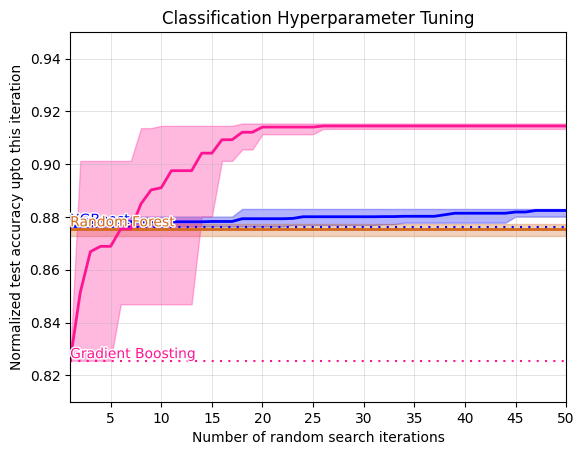

In [112]:
x = range(1, n_iterations+1)

xgboost_best_values = np.maximum.accumulate(clf_cat_xgboost_scores, axis = 1)
random_forest_best_values = np.maximum.accumulate(clf_cat_random_forest_scores, axis = 1)
gradient_boost_best_values = np.maximum.accumulate(clf_cat_gradient_boosting_scores, axis = 1)

plt.axhline(y=clf_cat_xgboost_scores[:, 0].mean(), color='blue', linestyle=(0, (1, 3)))
plt.axhline(y=clf_cat_random_forest_scores[:, 0].mean(), color='chocolate', linestyle=(0, (1, 3)))
plt.axhline(y=clf_cat_gradient_boosting_scores[:, 0].mean(), color='deeppink', linestyle=(0, (1, 3)))

text = plt.text(1, clf_cat_xgboost_scores[:, 0].mean() + 0.001, f'XGBoost', color='blue')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])
text = plt.text(1, clf_cat_random_forest_scores[:, 0].mean() + 0.001, f'Random Forest', color='chocolate')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])
text = plt.text(1, clf_cat_gradient_boosting_scores[:, 0].mean() + 0.001, f'Gradient Boosting', color='deeppink')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

plt.plot(x, xgboost_best_values.mean(axis=0), label='XGBoost', color='blue', linewidth=2)
plt.plot(x, random_forest_best_values.mean(axis=0), label='Random Forest', color='chocolate', linewidth=2)
plt.plot(x, gradient_boost_best_values.mean(axis=0), label='Gradient Boosting', color='deeppink', linewidth=2)

plt.fill_between(x, xgboost_best_values.min(axis=0), xgboost_best_values.max(axis=0), color='blue', alpha=0.3)
plt.fill_between(x, random_forest_best_values.min(axis=0), random_forest_best_values.max(axis=0), color='chocolate', alpha=0.3)
plt.fill_between(x, gradient_boost_best_values.min(axis=0), gradient_boost_best_values.max(axis=0), color='deeppink', alpha=0.3)

plt.xticks(range(0, n_iterations+1, 5))
plt.ylim(0.81, 0.95)
plt.xlim(1, n_iterations)

plt.ylabel('Normalized test accuracy upto this iteration')
plt.xlabel('Number of random search iterations')
plt.title('Classification Hyperparameter Tuning')
plt.grid(True, which='both', linewidth=0.5, alpha=0.5)